# Example of using mlconfound during internal and external validation

In [2]:
import warnings
import os
from os.path import join
import numpy as np
import pandas as pd
from scipy.stats import kurtosis, skew

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import VarianceThreshold
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import quantile_transform
from sklearn.metrics import roc_curve, RocCurveDisplay
from nilearn.datasets.utils import _uncompress_file, _fetch_file
from nilearn.connectome import ConnectivityMeasure

from neurocombat_sklearn import CombatModel

import statsmodels.api as sm
from statsmodels.regression.linear_model import OLS
from statsmodels.formula.api import ols as ols_f

from mlconfound.stats import full_confound_test, partial_confound_test
from mlconfound.plot import plot_graph
from mlconfound.stats import _r2_cat_cont, _r2_cont_cont, _r2_cat_cat

## Load data

In [3]:
data_dir = '../data/ABIDE'

url = 'https://osf.io/hc4md/download'

# Download the zip file, first
dl_file = _fetch_file(url, data_dir=data_dir)

# Second, uncompress the downloaded zip file
_uncompress_file(dl_file, verbose=2)


Downloaded 1807892480 of 1811491701 bytes (99.8%,    0.3s remaining) ...done. (148 seconds, 2 min)
Extracting data from data/ABIDE/download..... done.


In [79]:
def _get_paths(phenotypic, atlas, timeseries_dir):
    timeseries = []
    IDs_subject = []
    diagnosis = []
    subject_ids = phenotypic['SUB_ID']
    mean_fd = []
    num_fd = []
    perc_fd = []
    site = []
    ados = []
    fiq = []
    srs = []
    for index, subject_id in enumerate(subject_ids):
        this_pheno = phenotypic[phenotypic['SUB_ID'] == subject_id]
        this_timeseries = join(timeseries_dir, atlas,
                               str(subject_id) + '_timeseries.txt')
        if os.path.exists(this_timeseries):
            timeseries.append(np.loadtxt(this_timeseries))
            IDs_subject.append(subject_id)
            diagnosis.append(this_pheno['DX_GROUP'].values[0])
            mean_fd.append(this_pheno['func_mean_fd'].values[0])
            num_fd.append(this_pheno['func_num_fd'].values[0])
            perc_fd.append(this_pheno['func_perc_fd'].values[0])
            site.append(this_pheno['SITE_ID'].values[0])
            ados.append(this_pheno['ADOS_TOTAL'].values[0])
            fiq.append(this_pheno['FIQ'].values[0])
            srs.append(this_pheno['SRS_RAW_TOTAL'].values[0])
    return timeseries, diagnosis, IDs_subject, mean_fd, num_fd, perc_fd, site, ados, fiq, srs

Download the phenotypic summary information file form the preprocessed connectomes project.
- First read:
  http://preprocessed-connectomes-project.org/abide/download.html
- Then download:
  https://s3.amazonaws.com/fcp-indi/data/Projects/ABIDE_Initiative/Phenotypic_V1_0b_preprocessed1.csv
- Copy the csv file into the data_in/ABIDE directory

In [80]:
phenotypic = pd.read_csv('../data/ABIDE/Phenotypic_V1_0b_preprocessed1.csv').iloc[:,2:]
timeseries, diagnosis, IDs_subject, mean_fd, num_fd, perc_fd, site, ados, fiq, srs = _get_paths(phenotypic, "BASC/regions", '../data/ABIDE/')
sites, site_int = np.unique(site, return_inverse=True)
phenotypic

,SUB_ID,X,subject,SITE_ID,FILE_ID,DX_GROUP,DSM_IV_TR,AGE_AT_SCAN,SEX,HANDEDNESS_CATEGORY,...,qc_notes_rater_1,qc_anat_rater_2,qc_anat_notes_rater_2,qc_func_rater_2,qc_func_notes_rater_2,qc_anat_rater_3,qc_anat_notes_rater_3,qc_func_rater_3,qc_func_notes_rater_3,SUB_IN_SMP
0,50002,1,50002,PITT,no_filename,1,1,16.77,1,Ambi,...,NaN,OK,NaN,fail,ic-parietal-cerebellum,OK,NaN,fail,ERROR #24,1
1,50003,2,50003,PITT,Pitt_0050003,1,1,24.45,1,R,...,NaN,OK,NaN,OK,NaN,OK,NaN,OK,NaN,1
2,50004,3,50004,PITT,Pitt_0050004,1,1,19.09,1,R,...,NaN,OK,NaN,OK,NaN,OK,NaN,OK,NaN,1
3,50005,4,50005,PITT,Pitt_0050005,1,1,13.73,2,R,...,NaN,OK,NaN,maybe,ic-parietal-cerebellum,OK,NaN,OK,NaN,0
4,50006,5,50006,PITT,Pitt_0050006,1,1,13.37,1,L,...,NaN,OK,NaN,maybe,ic-parietal slight,OK,NaN,OK,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1107,51583,1108,51583,SBL,SBL_0051583,1,2,35.00,1,NaN,...,NaN,OK,NaN,OK,ic-cerebellum-temporal_lobe,OK,NaN,OK,NaN,0
1108,51584,1109,51584,SBL,SBL_0051584,1,2,49.00,1,NaN,...,NaN,OK,NaN,maybe,vmpfc dropout,OK,NaN,OK,NaN,0
1109,51585,1110,51585,SBL,SBL_0051585,1,1,27.00,1,NaN,...,NaN,OK,NaN,maybe,ic-cerebellum-temporal_lobe,OK,NaN,OK,NaN,0
1110,51606,1111,51606,MAX_MUN,MaxMun_a_0051606,1,2,29.00,2,R,...,NaN,OK,NaN,maybe,ic-cerebellum,OK,NaN,OK,NaN,0


In [78]:
np.unique(site, return_counts=True)

(array(['CALTECH', 'CMU', 'KKI', 'LEUVEN_1', 'LEUVEN_2', 'MAX_MUN', 'NYU',
        'OHSU', 'OLIN', 'PITT', 'SBL', 'SDSU', 'STANFORD', 'TRINITY',
        'UCLA_1', 'UCLA_2', 'UM_1', 'UM_2', 'USM', 'YALE'], dtype='<U8'),
 array([ 15,  10,  32,  28,  28,  46, 172,  25,  28,  50,  26,  26,  25,
         44,  64,  21,  85,  34,  67,  40]))

In [36]:
ados

0         12.0
1         13.0
2         18.0
3         12.0
4         12.0
         ...  
1107   -9999.0
1108      12.0
1109   -9999.0
1110       NaN
1111       NaN
Name: ADOS_TOTAL, Length: 1112, dtype: float64

[13.0,
 18.0,
 12.0,
 12.0,
 17.0,
 16.0,
 -9999.0,
 13.0,
 12.0,
 12.0,
 16.0,
 19.0,
 10.0,
 -9999.0,
 12.0,
 -9999.0,
 11.0,
 8.0,
 13.0,
 11.0,
 -9999.0,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 9.0,
 nan,
 8.0,
 7.0,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 14.0,
 8.0,
 17.0,
 15.0,
 14.0,
 9.0,
 11.0,
 15.0,
 19.0,
 7.0,
 19.0,
 19.0,
 12.0,
 18.0,
 7.0,
 14.0,
 13.0,
 9.0,
 7.0,
 4.0,
 9.0,
 5.0,
 14.0,
 8.0,
 11.0,
 10.0,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 7.0,
 17.0,
 7.0,
 19.0,
 10.0,
 12.0,
 10.0,
 9.0,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 9.0,
 7.0,
 10.0,
 8.0,
 17.0,
 11.0,
 9.0,
 10.0,
 9.0,
 12.0,
 7.0,
 15.0,
 13.0,
 11.0,
 14.0,
 8.0,
 11.0,
 13.0,
 10.0,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,

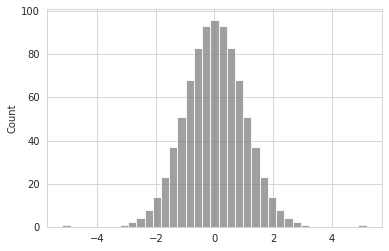

In [37]:
rng = np.random.default_rng(42)
mean_fd_trf = quantile_transform(np.array([mean_fd]).T, output_distribution='normal',
                                 n_quantiles=len(mean_fd)).flatten()

sns.histplot(mean_fd_trf, color='gray')
plt.savefig('../fig/raw/emp_abide_motion_quanttrf_hist.pdf')

kurtosis(mean_fd_trf), skew(mean_fd_trf)
mean_fd = mean_fd_trf


## Binning motion data (to be used later)

In [38]:
# binning mean_fd
bins = 10 # approximately 80 subject per motion group

limits = np.quantile(mean_fd, np.arange(0, 1, 1/bins))
mean_fd_binned = np.digitize(mean_fd, limits)

## Calculate connectivity

In [39]:
connections = ConnectivityMeasure(kind='tangent', vectorize=True, discard_diagonal=True)
conn_coefs = connections.fit_transform(timeseries)

In [40]:
_, y = np.unique(diagnosis, return_inverse=True)
X = conn_coefs

In [58]:
# Train on the NYU site only
X_NYU = X[np.array(site) == 'NYU']
y_NYU = y[np.array(site) == 'NYU']

outer_cv = StratifiedKFold(10)
inner_cv = StratifiedKFold(10)
model = Pipeline([
    ('varthr', VarianceThreshold(0)),   # omit zero variance columns (diagonal)
    ('model', LogisticRegression())])

p_grid = {'model__C': [0.1, 1, 10]}

clf = GridSearchCV(estimator=model, param_grid=p_grid, cv=StratifiedKFold(10),
                   scoring="roc_auc", return_train_score=False,
                   n_jobs=-1)

all_models = []
best_params = []
predicted = np.zeros(len(y_NYU))
predicted_prob = np.zeros(len(y_NYU))
nested_scores_train = np.zeros(outer_cv.get_n_splits(X_NYU))
nested_scores_test = np.zeros(outer_cv.get_n_splits(X_NYU))

print("model\tinner_cv mean score\touter vc score")
ii=0
for train, test in outer_cv.split(X_NYU, y_NYU):

    # regress out within the cv
    X_adj = np.zeros_like(X_NYU)
    for i in range(X_NYU.shape[1]):
        tmp = pd.DataFrame({
            'mean_fd': mean_fd[np.array(site) == 'NYU'][train],
            'y': X_NYU[train,i]
        })

        OLS_model = ols_f("y ~ mean_fd", tmp).fit()
        X_adj[train, i] = OLS_model.resid

        tmp2 = pd.DataFrame({
            'mean_fd': mean_fd[np.array(site) == 'NYU'][test]
        })
        X_adj[test, i] = X_NYU[test,i] - OLS_model.predict(tmp2)
    clf.fit(X_adj[train], y_NYU[train])

    print('cv:', ii, str(clf.best_params_) + " " + str(clf.best_score_) + " " + str(clf.score(X_adj[test], y_NYU[test])))

    all_models.append(clf.best_estimator_)
    best_params.append(clf.best_params_)

    predicted[test] = clf.predict(X_NYU[test])
    predicted_prob[test] = clf.predict_proba(X_adj[test])[:,0]

    nested_scores_train[ii] = clf.best_score_
    nested_scores_test[ii] = clf.score(X_adj[test], y_NYU[test])
    ii = ii+1

finalized_model = clf.fit(X_NYU, y_NYU)

model	inner_cv mean score	outer vc score
cv: 0 {'model__C': 0.1} 0.4333333333333333 0.5
cv: 1 {'model__C': 0.1} 0.41759259259259257 0.6875
cv: 2 {'model__C': 0.1} 0.41335978835978837 0.6527777777777778
cv: 3 {'model__C': 0.1} 0.4355820105820106 0.6666666666666667
cv: 4 {'model__C': 0.1} 0.40634920634920635 0.35714285714285715
cv: 5 {'model__C': 0.1} 0.4226851851851852 0.6428571428571429
cv: 6 {'model__C': 0.1} 0.4048941798941799 0.8857142857142858
cv: 7 {'model__C': 0.1} 0.3825396825396825 0.6428571428571429
cv: 8 {'model__C': 0.1} 0.35780423280423285 0.6285714285714286
cv: 9 {'model__C': 0.1} 0.39880952380952384 0.7


In [ ]:
print("** Mean score in the inner crossvaludation (inner_cv):\t" + str(nested_scores_train.mean()))
print("** Mean Nested Crossvalidation Score (outer_cv):\t" + str(nested_scores_test.mean()))

fpr, tpr, _ = roc_curve(y[np.array(site) == 'NYU'], predicted_prob, pos_label=0)
fig, ax = plt.subplots(figsize=(2,2))
RocCurveDisplay(fpr=fpr, tpr=tpr).plot(ax=ax)

In [ ]:
plot_graph(partial_confound_test(y[np.array(site) == 'NYU'], predicted, mean_fd[np.array(site) == 'NYU'], random_state=42))

In [96]:
X_USM = X[np.array(site)=='UCLA_1']
X_USM_adj = np.zeros_like(X_USM)
for i in range(X_NYU.shape[1]):
    tmp = pd.DataFrame({
        'mean_fd': np.array(mean_fd)[np.array(site) == 'UCLA_1'],
        'y': X_USM[:,i]
    })
    OLS_model = ols_f("y ~ mean_fd", tmp).fit()
    X_USM_adj[:, i] = OLS_model.resid

predicted_USM = finalized_model.predict_proba(X_USM_adj)[:,0]


Permuting: 100%|██████████| 1000/1000 [00:01<00:00, 504.23it/s]


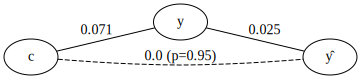

In [97]:
plot_graph(partial_confound_test(y[np.array(site) == 'UCLA_1'], predicted_USM, np.array(mean_fd)[np.array(site) == 'UCLA_1'], random_state=42))

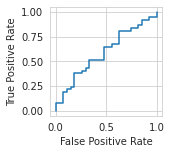

In [98]:
fpr, tpr, _ = roc_curve(y[np.array(site) == 'UCLA_1'], predicted_USM, pos_label=0)
fig, ax = plt.subplots(figsize=(2,2))
RocCurveDisplay(fpr=fpr, tpr=tpr).plot(ax=ax)

In [99]:
plot_graph(partial_confound_test(y[np.array(site) == 'UCLA_1'], predicted_USM, np.array(ados)[np.array(site) == 'UCLA_1'], random_state=42))

ValueError: y data must not contain Inf nor NaN

Permuting: 100%|██████████| 1000/1000 [00:00<00:00, 1648.74it/s]


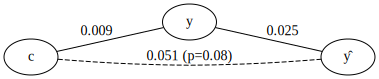

In [100]:
plot_graph(partial_confound_test(y[np.array(site) == 'UCLA_1'], predicted_USM, np.array(fiq)[np.array(site) == 'UCLA_1'], random_state=42))

In [102]:
plot_graph(partial_confound_test(y[np.array(site) == 'USM'], predicted_USM, np.array(fiq)[np.array(site) == 'USM'], random_state=42))

ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 64 and the array at index 1 has size 67

In [91]:
X_USM = X[np.array(site) == 'USM']
X_USM_adj = np.zeros_like(X_USM)
for i in range(X_NYU.shape[1]):
    tmp = pd.DataFrame({
        'mean_fd': mean_fd[np.array(site) == 'USM'],
        'y': X_USM[:, i]
    })
    OLS_model = ols_f("y ~ mean_fd", tmp).fit()
    X_USM_adj[:, i] = OLS_model.resid

predicted_USM = finalized_model.predict_proba(X_USM_adj)[:, 0]

plot_graph(partial_confound_test(y[np.array(site) == 'USM'], predicted_USM, np.array(mean_fd)[np.array(site) == 'USM'],
                                 random_state=42))
fpr, tpr, _ = roc_curve(y[np.array(site) == 'USM'], predicted_USM, pos_label=0)
fig, ax = plt.subplots(figsize=(2, 2))
RocCurveDisplay(fpr=fpr, tpr=tpr).plot(ax=ax)
plot_graph(partial_confound_test(y[np.array(site) == 'USM'], predicted_USM, np.array(ados)[np.array(site) == 'USM'],
                                 random_state=42))
plot_graph(partial_confound_test(y[np.array(site) == 'USM'], predicted_USM, np.array(fiq)[np.array(site) == 'USM'],
                                 random_state=42))
plot_graph(partial_confound_test(y[np.array(site) == 'USM'], predicted_USM, np.array(srs)[np.array(site) == 'USM'],
                                 random_state=42))